# CpE Elective 3 Laboratory (LBYCPC4) <br/>
#### Computer Vision and Deep Learning Elective Track
<br/>
<hr style="border:5px solid gray">


## Activity 4: Text Generation Models

### Introduction
&emsp;&emsp;&emsp;Generative models have become increasingly powerful tools for generating human-like text. Among these models include Long Short-Term Memory (LSTM) and Gated Recurrent Units (GRU) which were well-suited for text generation. While LSTMs and GRUs can capture some long-range dependencies, they may struggle to model global dependencies across the entire sequence.

The Transformer model, introduced in the paper "Attention Is All You Need" by Vaswani et al. (2017) [1], built upon the attention mechanism introduced in [2] and fundamentally changed the way deep learning handles sequence-based tasks. It eliminated the need for recurrent networks like RNNs or LSTMs by relying entirely on self-attention mechanisms. Transformers have since become the backbone for state-of-the-art models like BERT and GPT.

### Objectives
- Familiarize with the architecture of LSTM and GRU models
- Familiarize with the transformer architecture
- Build and train various text generation models using deep learning framework
- Assess the performance of the model's ability to generate text accurately

### Activity

Execute the code cells below to install the required Python packages and libraries.

In [ ]:
# Install preliminary Python packages
!pip install -q tensorflow-datasets
!pip install -q --upgrade keras-nlp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.4/548.4 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 19.1 MB/s eta 0:00:00


In [ ]:
# Import libraries
import keras
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

**A. Text Generation with RNN Models**

1. Acquire the [WikiAuto  Dataset](https://github.com/chaojiang06/wiki-auto), a collection of datasets for long-form narrative summarization. Show several sample texts from the training dataset.

In [ ]:
# Get the wiki-auto dataset. Load the wiki_auto/manual configuration
# https://www.tensorflow.org/datasets/catalog/wiki_auto
# Save the dev split to variable ds_train
# Save the test split to variable ds_test
# Save the dataset info to variable ds_info
### --YOUR CODE HERE-- ###
ds_dev, ds_info = tfds.load('wiki_auto/manual', with_info=True, split= ['dev', 'test'])
ds_train = ds_dev[0]
ds_test = ds_dev[1]
# Preprocess the dataset to include only the 'simple_sentence' feature
ds_train = ds_train.map(lambda x: x["simple_sentence"])
ds_test = ds_test.map(lambda x: x["simple_sentence"])

ds_train_text = str()
for text in ds_train:
  ds_train_text += text.numpy().decode() + "\n"

ds_test_text = str()
for text in ds_test:
  ds_test_text += text.numpy().decode() + "\n"

# Display at least five (5) sample texts from the dataset, one per row
### --YOUR CODE HERE-- ###
for sample in ds_train.take(5):
    print(sample.numpy().decode())



Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating dev examples...:   0%|          | 0/73249 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/wiki_auto/manual/incomplete.VOUAAO_1.0.0/wiki_auto-dev.tfrecord*...:   0%|…

Generating test examples...:   0%|          | 0/118074 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/wiki_auto/manual/incomplete.VOUAAO_1.0.0/wiki_auto-test.tfrecord*...:   0%…

Dataset wiki_auto downloaded and prepared to /root/tensorflow_datasets/wiki_auto/manual/1.0.0. Subsequent calls will reuse this data.
Sodium hydroxide can be made (with chlorine and hydrogen) using the chloralkali process.
At first Bilbo does not want to, but later he goes with them.
A syphon can raise water to a height of 25 feet above the source elevation.
The Wood-Elves capture the dwarves.
The commerce is not really clean, but since the rules require a consensus they cannot be removed unless everybody agrees.


2. Execute the code below to preprocess and tokenize the text. Understand the code and explain its function in the final report.

In [ ]:
# Import functions and classes from Keras library
from keras.utils import to_categorical

# Specify the sequence length
seq_len = 50

# Define the vocabulary dictionaries
vocabulary = sorted(list(set(ds_train_text + ds_test_text)))
chr2idx = {c: i for i, c in enumerate(vocabulary)}
idx2chr = {i: c for i, c in enumerate(vocabulary)}
vocab_size = len(vocabulary)

# Build the training dataset
slide_size = 10
input_tokens, target_tokens = [], []
for i in range(0, len(ds_train_text) - seq_len, slide_size):
  input_tokens.append([chr2idx[ch] for ch in ds_train_text[i:i + seq_len]])
  target_tokens.append(chr2idx[ds_train_text[i + seq_len]])

seqX = tf.convert_to_tensor(input_tokens)
seqy = to_categorical(tf.convert_to_tensor(target_tokens),
                      num_classes=vocab_size)

# Define the Tensorflow dataset for training
ds_train = tf.data.Dataset.from_tensor_slices((seqX, seqy))

# Build the testing dataset
input_tokens, target_tokens = [], []
for i in range(0, len(ds_test_text[:1000000]) - seq_len, slide_size):
  input_tokens.append([chr2idx[ch] for ch in ds_test_text[i:i + seq_len]])
  target_tokens.append(chr2idx[ds_test_text[i + seq_len]])

seqX = tf.convert_to_tensor(input_tokens)
seqy = to_categorical(tf.convert_to_tensor(target_tokens),
                      num_classes=vocab_size)

# Define the Tensorflow dataset for testing
ds_test = tf.data.Dataset.from_tensor_slices((seqX, seqy))

<_TensorSliceDataset element_spec=(TensorSpec(shape=(50,), dtype=tf.int32, name=None), TensorSpec(shape=(106,), dtype=tf.float32, name=None))>


3. Build the RNN model using the [LSTM](https://keras.io/api/layers/recurrent_layers/lstm/) layer as illustrated below.
<center><img src="https://drive.google.com/uc?export=view&id=1z1F1lzvEjLOfnooX1avcHBnmTZO7gkmw"></center>

In [ ]:
# Import functions and classes from Keras library
from keras import Input, Sequential
from keras.layers import Embedding, LSTM, Dropout, Dense

# Create the RNN that uses LSTM. Save it to rnn_lstm variable
# The Embedding layer should have 128-dimensional output vector
# Yuu may use a reasonable rate for the Dropout layer
### --YOUR CODE HERE-- ###

rnn_lstm = Sequential([
    Input(shape=(50,)),
    Embedding(input_dim=vocab_size, output_dim=128),
    LSTM(units=256, activation='tanh', return_sequences=False),
    Dropout(rate=0.5),
    Dense(units=vocab_size, activation='softmax')
])

rnn_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 50, 128)             │          13,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 256)                 │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 106)                 │          27,242 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 435,050 (1.66 MB)

 Trainable params: 435,050 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

4. Configure the network for training. Then train the model with a batch size of your choice. Make sure to save the history of losses per training epoch.

In [ ]:
# Configure the network for training
# Use the appropriate loss function
# You may use Adam as optimizer
### --YOUR CODE HERE-- ###
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

rnn_lstm.compile(
    optimizer=Adam(learning_rate=0.0003),
    loss=BinaryCrossentropy(from_logits=False),
)

# Train the model. Set the number of epochs accordingly
# Set the dataset batch size of your choice
# Assign the output to rnn_lstm_hist variable
### --YOUR CODE HERE-- ###
batch_size = 100
rnn_lstm_hist = rnn_lstm.fit(ds_train.batch(batch_size), epochs=10)

Epoch 1/10
6633/6633 ━━━━━━━━━━━━━━━━━━━━ 63s 9ms/step - loss: 0.0536
Epoch 2/10
6633/6633 ━━━━━━━━━━━━━━━━━━━━ 65s 10ms/step - loss: 0.0300
Epoch 3/10
6633/6633 ━━━━━━━━━━━━━━━━━━━━ 59s 9ms/step - loss: 0.0277
Epoch 4/10
6633/6633 ━━━━━━━━━━━━━━━━━━━━ 62s 9ms/step - loss: 0.0260
Epoch 5/10
6633/6633 ━━━━━━━━━━━━━━━━━━━━ 59s 9ms/step - loss: 0.0246
Epoch 6/10
6633/6633 ━━━━━━━━━━━━━━━━━━━━ 60s 9ms/step - loss: 0.0234
Epoch 7/10
6633/6633 ━━━━━━━━━━━━━━━━━━━━ 59s 9ms/step - loss: 0.0222
Epoch 8/10
6633/6633 ━━━━━━━━━━━━━━━━━━━━ 58s 9ms/step - loss: 0.0212
Epoch 9/10
6633/6633 ━━━━━━━━━━━━━━━━━━━━ 83s 9ms/step - loss: 0.0203
Epoch 10/10
6633/6633 ━━━━━━━━━━━━━━━━━━━━ 59s 9ms/step - loss: 0.0193


5. Plot the training losses per epoch. Place appropriate plot title and axis labels.

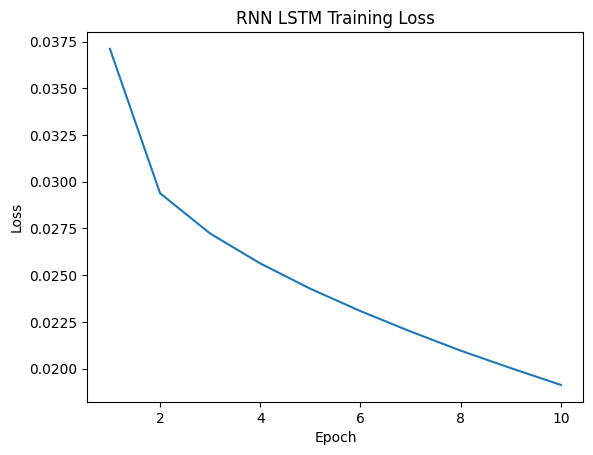

In [ ]:
# Extract the losses during training
### --YOUR CODE HERE-- ###
rnn_lstm_loss = rnn_lstm_hist.history['loss']
epochs = range(1, len(rnn_lstm_loss) + 1)

# Plot the history of losses
### --YOUR CODE HERE-- ###
plt.plot(epochs, rnn_lstm_loss)
plt.title('RNN LSTM Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

6. Obtain at least five (5) generated text samples from the model. Use a subset of the test dataset as seed inputs. Assess the performance of your model using the Perplexity metric. You may refer to [Perplexity metric](https://keras.io/api/keras_nlp/metrics/perplexity/) for documentation. Interpret the results in your final report.

In [ ]:
# Define the function to convert model output to character
def predictions_to_char(predictions, temperature=1.0):
  predictions = np.asarray(predictions).astype("float64")
  exp_predictions = np.exp(np.log(predictions) / temperature)
  predictions = exp_predictions / np.sum(exp_predictions)
  probabilities = np.random.multinomial(1, predictions, 1)
  return idx2chr[np.argmax(probabilities)]

# Get at least (5) seed sentences from the test dataset
# Obtain model output for each sentence and use the function defined above
# Generate a sentence that is at least 100 characters in length
# after the seed sentence.
# Save the seed sentences to a list (not TFDS) named seed_sentences
# Save the next character for each sentence to a list named next_chars
### --YOUR CODE HERE-- ###

seed_sentences = []
next_chars = []

for sentence in ds_test.take(5):
    seed_array = sentence[0].numpy()
    seed = ''.join([idx2chr[i] for i in seed_array])
    seed_sentences.append(seed)
    next_chars.append(seed[1])


# Iterate through selected seed sentences and show the generated sentences
for idx, seed_sentence in enumerate(seed_sentences):
  print(f"Sample sentence {idx + 1}:")
  print(seed_sentence, end="")
  for _ in range(100):
    seed_tokens = tf.convert_to_tensor([[chr2idx[ch] for ch in seed_sentence]])
    predictions = rnn_lstm.predict(seed_tokens, verbose=0)
    next_char = predictions_to_char(predictions[0], temperature=0.5)
    seed_sentence = seed_sentence[1:] + next_char
    print(next_char, end="")
  print("\n")

# Compute the perplexity metric for each seed sentence as you selected above
# Use the saved next character as ground truth
# Import Perplexity metric from Keras NLP
from keras_nlp.metrics import Perplexity
### --YOUR CODE HERE-- ###

perplexity = Perplexity()

for idx, (seed_sentence, next_char) in enumerate(zip(seed_sentences, next_chars)):
    seed_tokens = tf.convert_to_tensor([[chr2idx[ch] for ch in seed_sentence]])
    predictions = rnn_lstm.predict(seed_tokens, verbose=0)
    predictions = tf.reshape(predictions, (1, -1))
    ground_truth = chr2idx[next_char]
    true_char = tf.constant([[ground_truth]], dtype=tf.int64)
    perplexity.update_state(true_char, predictions)
    print(f"Perplexity for seed sentence {idx + 1}: {perplexity.result().numpy()}")
    perplexity.reset_state()

Sample sentence 1:
They have 21 digits.
In May 2002, Frank Iero joine is and to the dwarves of It was of the propiced into the solice to the solution of a thrist of the 

Sample sentence 2:
21 digits.
In May 2002, Frank Iero joined as the reating of 1970 was sent in the police selbor dound were solved in the tomerucing the dwarves and Bil

Sample sentence 3:

In May 2002, Frank Iero joined as the rhythm guit is a fore the dwarves.
Bilbo names the dwarves and Bilbo pave of the somecited in the somecised to 

Sample sentence 4:
02, Frank Iero joined as the rhythm guitarist for the solutions in the trace the somecial used to and the liquid in the lace their to the governed and

Sample sentence 5:
Iero joined as the rhythm guitarist for the band.
The conside ald of the ring and consinge to and many tiles.
The dwarves and his gouse of the Lonely 

Perplexity for seed sentence 1: 245023.890625
Perplexity for seed sentence 2: 10000074.0
Perplexity for seed sentence 3: 10000055.0
Perplexity fo

7. Repeat step A.6 but experiment with different values of `temperature` parameter of the `predictions_to_char()` function. How does the paramater affect the quality of the generated text? Write your observations in the final report.

In [ ]:
# Use the following temperature values
temp_vals = [0.2, 0.5, 1.5, 2.0]

# Repeat step A.6 but with different temperature values defined above
### --YOUR CODE HERE-- ###
# Iterate through selected seed sentences and show the generated sentences
for idx, seed_sentence in enumerate(seed_sentences):
    print(f"Sample sentence {idx + 1}:")
    print(f"Seed: {seed_sentence}")

    for temp in temp_vals:
        print(f"\nTemperature: {temp}")
        generated_sentence = seed_sentence
        print(generated_sentence, end="")
        for _ in range(100):
            seed_tokens = tf.convert_to_tensor([[chr2idx[ch] for ch in generated_sentence]])
            predictions = rnn_lstm.predict(seed_tokens, verbose=0)
            next_char = predictions_to_char(predictions[0], temperature=temp)
            generated_sentence = generated_sentence[1:] + next_char
            print(next_char, end="")
        print("\n")
    print("-" * 50)

# Compute the perplexity metric for each seed sentence
perplexity = Perplexity()

for idx, (seed_sentence, next_char) in enumerate(zip(seed_sentences, next_chars)):
    seed_tokens = tf.convert_to_tensor([[chr2idx[ch] for ch in seed_sentence]])
    predictions = rnn_lstm.predict(seed_tokens, verbose=0)

    predictions = tf.reshape(predictions, (1, -1))
    true_char_index = chr2idx[next_char]
    true_char = tf.constant([[true_char_index]], dtype=tf.int64)

    perplexity.update_state(true_char, predictions)

    print(f"Perplexity for sentence {idx + 1}: {perplexity.result().numpy()}")
    perplexity.reset_state()

Sample sentence 1:
Seed: They have 21 digits.
In May 2002, Frank Iero joine

Temperature: 0.2
They have 21 digits.
In May 2002, Frank Iero joine of the Lonely Mountain, and continue to the dwarves.
The solice them andalf them the solite the sol


Temperature: 0.5
They have 21 digits.
In May 2002, Frank Iero joine of the was an areacter for their intonaling the into the solitical commanites.
Bilbo store the dwar


Temperature: 1.5
They have 21 digits.
In May 2002, Frank Iero joined, hes at laze fack.
Love, liquid comes siorsend Corkedmethin's lakes whean flog the spicbe of Chori


Temperature: 2.0
They have 21 digits.
In May 2002, Frank Iero joine.
Naw TV. twen remalitict maOH6 of the topingle aid mujo's" by "Iwh Iad sapcuxide "Prkevem Thr57 Ago

--------------------------------------------------
Sample sentence 2:
Seed: 21 digits.
In May 2002, Frank Iero joined as the r

Temperature: 0.2
21 digits.
In May 2002, Frank Iero joined as the rearing the dwarves.
The solice them andalf them t

8. Repeat step A.3 by creating a new model using a [GRU](https://keras.io/api/layers/recurrent_layers/gru/) layer. Repeat steps A.4 to A.6. Document the training time and the perplexity value. Compare the results for both models and draw appropriate conclusions. Write your observations in the final report.

In [ ]:
# Create the RNN that uses GRU. Save it to rnn_gru variable
### --YOUR CODE HERE-- ###

from keras.layers import GRU
from keras_nlp.metrics import Perplexity
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

rnn_gru = Sequential([
    Input(shape=(50,)),
    Embedding(input_dim=vocab_size, output_dim=128,name="embedding_gru"),
    GRU(units=256, activation='tanh', return_sequences=False, name="gru"),
    Dropout(rate=0.5,name="dropout_gru"),
    Dense(units=vocab_size, activation='softmax',name='dense_gru')
])
rnn_gru.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_gru (Embedding)            │ (None, 50, 128)             │          13,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 256)                 │         296,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_gru (Dropout)                │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_gru (Dense)                    │ (None, 106)                 │          27,242 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 337,258 (1.29 MB)

 Trainable params: 337,258 (1.29 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
6633/6633 ━━━━━━━━━━━━━━━━━━━━ 56s 8ms/step - loss: 0.0210
Epoch 2/10
6633/6633 ━━━━━━━━━━━━━━━━━━━━ 54s 8ms/step - loss: 0.0188
Epoch 3/10
6633/6633 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - loss: 0.0171
Epoch 4/10
6633/6633 ━━━━━━━━━━━━━━━━━━━━ 54s 8ms/step - loss: 0.0158
Epoch 5/10
6633/6633 ━━━━━━━━━━━━━━━━━━━━ 55s 8ms/step - loss: 0.0148
Epoch 6/10
6633/6633 ━━━━━━━━━━━━━━━━━━━━ 54s 8ms/step - loss: 0.0140
Epoch 7/10
6633/6633 ━━━━━━━━━━━━━━━━━━━━ 54s 8ms/step - loss: 0.0134
Epoch 8/10
6633/6633 ━━━━━━━━━━━━━━━━━━━━ 55s 8ms/step - loss: 0.0129
Epoch 9/10
6633/6633 ━━━━━━━━━━━━━━━━━━━━ 54s 8ms/step - loss: 0.0124
Epoch 10/10
6633/6633 ━━━━━━━━━━━━━━━━━━━━ 83s 8ms/step - loss: 0.0120


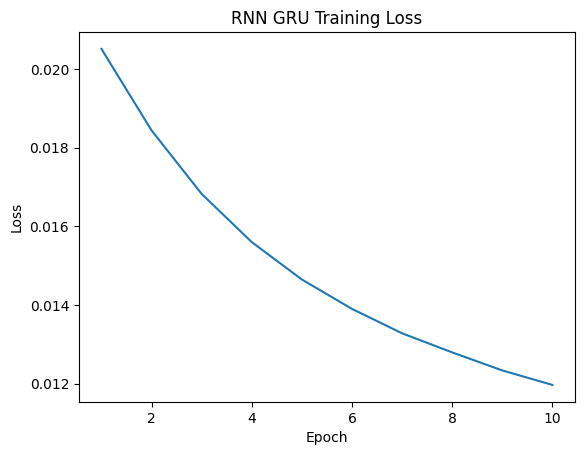

Sample sentence 1:
They have 21 digits.
In May 2002, Frank Iero joine way of example.
The top of the tube is where the lowest pressure is, so the liquid fill of the drag

Sample sentence 2:
21 digits.
In May 2002, Frank Iero joined as the reared of govern.
The hobbit Bilbo Baggins lives a quiet and peeped an an and from the most an ary on

Sample sentence 3:

In May 2002, Frank Iero joined as the rhythm guit on ofem on the proposala worlds of the treasures work so his with a groupone way then.
And of the r

Sample sentence 4:
02, Frank Iero joined as the rhythm guitarist for ofe of an army cannongs on the street comeling a light chouint for his relial and sensers condirican

Sample sentence 5:
Iero joined as the rhythm guitarist for the band.
The dwarves are and unders and by the chart sold torced than the dwarves and Bilbo into the dwarves.

Perplexity for seed sentence 1: 245023.890625
Perplexity for seed sentence 2: 10000074.0
Perplexity for seed sentence 3: 10000055.0
Perplexity fo

In [ ]:
# Configure the network for training
# Use the Perplexity as an additional metric during training
# Assign the output to rnn_gru_hist variable
### --YOUR CODE HERE-- ###
from keras.optimizers import Adam
perplexity_m = Perplexity(from_logits=True)
rnn_gru.compile(
    optimizer=Adam(learning_rate=0.0003),
    loss=BinaryCrossentropy(from_logits=False),
)
# Configure the network for training
# Use the Perplexity as an additional metric during training
# Assign the output to rnn_gru_hist variable
### --YOUR CODE HERE-- ###
batch_size = 100
rnn_gru_hist = rnn_gru.fit(ds_train.batch(batch_size), epochs=10)

# Plot the history of losses and the perplexity values per epoch
### --YOUR CODE HERE-- ###
rnn_gru_loss = rnn_gru_hist.history['loss']
epochs = range(1, len(rnn_gru_loss) + 1)
plt.plot(epochs, rnn_gru_loss)
plt.title('RNN GRU Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# Obtain at least five (5) text predictions from the model
### --YOUR CODE HERE-- ###
seed_sentences = []
next_chars = []

for sentence in ds_test.take(5):
    seed_array = sentence[0].numpy()
    seed = ''.join([idx2chr[i] for i in seed_array])
    seed_sentences.append(seed)
    next_chars.append(seed[1])
for idx, seed_sentence in enumerate(seed_sentences):
  print(f"Sample sentence {idx + 1}:")
  print(seed_sentence, end="")
  for _ in range(100):
    seed_tokens = tf.convert_to_tensor([[chr2idx[ch] for ch in seed_sentence]])
    predictions = rnn_gru.predict(seed_tokens, verbose=0)
    next_char = predictions_to_char(predictions[0], temperature=0.5)
    seed_sentence = seed_sentence[1:] + next_char
    print(next_char, end="")
  print("\n")

perplexity = Perplexity()

for idx, (seed_sentence, next_char) in enumerate(zip(seed_sentences, next_chars)):
    seed_tokens = tf.convert_to_tensor([[chr2idx[ch] for ch in seed_sentence]])
    predictions = rnn_lstm.predict(seed_tokens, verbose=0)
    predictions = tf.reshape(predictions, (1, -1))
    ground_truth = chr2idx[next_char]
    true_char = tf.constant([[ground_truth]], dtype=tf.int64)
    perplexity.update_state(true_char, predictions)
    print(f"Perplexity for seed sentence {idx + 1}: {perplexity.result().numpy()}")
    perplexity.reset_state()

**B. Text Generation with Transformer Model**

1. Acquire and preprocess the [Race Dataset](https://www.cs.cmu.edu/%7Eglai1/data/race/), a large-scale reading comprehension dataset. Show a sample text from the training dataset.

In [ ]:
# Get the race dataset. Load the race/high configuration
# https://www.tensorflow.org/datasets/catalog/race
# Do not split the dataset. Combine all splits
# Save the dataset into race_ds variable
# Save the dataset info to variable ds_info
### --YOUR CODE HERE-- ###
race_ds, ds_info = tfds.load('race/high', with_info=True, split='train')
# Preprocess the dataset to include only the 'article' feature
### --YOUR CODE HERE-- ###
race_ds = race_ds.map(lambda x: x['article'])
# Display a sample text from the dataset
### --YOUR CODE HERE-- ###
for example in race_ds.take(1):
    print(example)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

2. Execute the code cells below that will prepare the dataset for word-level vectorization and preprocess it. Understand the code and explain its function in the final report.

In [ ]:
# Import functions and classes from Keras library
from keras.layers import TextVectorization

# Define vectorization parameters
vocab_size = 10000
seq_len = 50

# Define the text tokenizer layer and update
vectorizer = TextVectorization(
    max_tokens=vocab_size - 1,
    output_mode="int",
    output_sequence_length=seq_len + 1,
)
vectorizer.adapt(race_ds)
vocab = vectorizer.get_vocabulary()

In [ ]:
# Define the function that will preprocess the dataset
def ds_preprocess(text):
  text = tf.expand_dims(text, -1)
  tokenized_text = vectorizer(text)
  x = tokenized_text[0, :-1]
  y = tokenized_text[0, 1:]
  return x, y

# Apply preprocessing to the dataset
race_ds = race_ds.map(ds_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
race_ds = race_ds.prefetch(tf.data.AUTOTUNE)

3. Execute the code below that will define the `TokenAndPositionEmbedding` and `TransformerBlock` layers as custom Keras layers.

In [ ]:
# Import functions and classes from Keras library
from keras import ops, Sequential
from keras.layers import Layer, Embedding, Dense, Dropout
from keras.layers import MultiHeadAttention, LayerNormalization

# Define the TokenAndPositionEmbedding layer
# This layer creates two separate embeddings for tokens and token index
class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = ops.shape(x)[-1]
        positions = ops.arange(0, maxlen, 1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

# Define the TransformerBlock layer
# This layer is designed to capture long-range dependencies in sequential data
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = MultiHeadAttention(num_heads, embed_dim)
        self.ffn = Sequential(
            [
                Dense(ff_dim, activation="relu"),
                Dense(embed_dim),
            ]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs):
        input_shape = ops.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = self.causal_attention_mask(batch_size, seq_len,
                                                 seq_len, "bool")
        attention_output = self.att(inputs, inputs,
                                    attention_mask=causal_mask)
        attention_output = self.dropout1(attention_output)
        out1 = self.layernorm1(inputs + attention_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

    def causal_attention_mask(self, batch_size, n_dest, n_src, dtype):
      i = ops.arange(n_dest)[:, None]
      j = ops.arange(n_src)
      m = i >= j - n_src + n_dest
      mask = ops.cast(m, dtype)
      mask = ops.reshape(mask, [1, n_dest, n_src])
      mult = ops.concatenate(
          [ops.expand_dims(batch_size, -1), ops.convert_to_tensor([1, 1])], 0
      )
      return ops.tile(mask, mult)

4. Build the basic Generative Pre-Trained Transformer (GPT) model as illustrated below.
<center><img src="https://drive.google.com/uc?export=view&id=15sVLI7cRgizMchGNkdT-2lF-BpVhWm_Y"></center>

In [ ]:
# Import functions and classes from Keras library
from keras import Model, Input

# Define the model parameters
embed_dim = 256
num_heads = 2
feed_forward_dim  = 256

# Create the GPT model. Save it to gpt_model variable
# The input shape is the same as the maximum sequence length
# Save the input layer to gpt_input variable
# Save the TransformerBlock layer output to gpt_layer variable
# The last Dense layer has 50 output each having the same size as the vocabulary
# Save the last layer output to gpt_output variable
### --YOUR CODE HERE-- ###
gpt_input = Input(shape=(50,), dtype="int32", name="input_layer")
token_and_position_embedding = TokenAndPositionEmbedding(seq_len, vocab_size, embed_dim)(gpt_input)
gpt_layer = TransformerBlock(embed_dim, num_heads, feed_forward_dim)(token_and_position_embedding)
gpt_output = Dense(vocab_size, activation="linear", name="dense_2")(gpt_layer)

# Create the GPT model using the layers defined above
gpt_model = Model(gpt_input, [gpt_output, gpt_layer])
gpt_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_and_position_embedding         │ (None, 50, 256)             │       2,572,800 │
│ (TokenAndPositionEmbedding)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block (TransformerBlock) │ (None, 50, 256)             │         658,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 50, 10000)           │       2,570,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,801,488 (22.13 MB)

 Trainable params: 5,801,488 (22.13 MB)

 Non-trainable params: 0 (0.00 B)

5. Configure the model for training. Then train the model with a batch size of your choice. Make sure to save the history of losses per training epoch.

In [ ]:
# Import functions and classes from Keras library
from keras.losses import SparseCategoricalCrossentropy

# Configure the model for training
gpt_loss_fn = SparseCategoricalCrossentropy(from_logits=True)
gpt_model.compile(loss=[gpt_loss_fn, None], optimizer="adam")

# Train the model. Set the dataset batch size of your choice
# Assign the output to gpt_hist variable
### --YOUR CODE HERE-- ###
gpt_hist = gpt_model.fit(race_ds.batch(32), epochs=10)

Epoch 1/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - loss: 6.5092
Epoch 2/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 5.2471
Epoch 3/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - loss: 4.8110
Epoch 4/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 4.4983
Epoch 5/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 4.2452
Epoch 6/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 4.0342
Epoch 7/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 3.8515
Epoch 8/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 3.6910
Epoch 9/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 3.5462
Epoch 10/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 3.4199


6. Plot the training losses per epoch. Place appropriate plot title and axis labels.

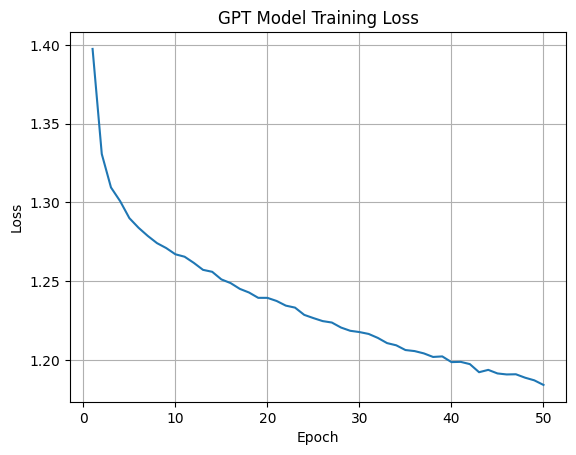

In [ ]:
# Extract the losses during training
### --YOUR CODE HERE-- ###
gpt_loss = gpt_hist.history['loss']
epochs = range(1, len(gpt_loss) + 1)

# Plot the history of losses
### --YOUR CODE HERE-- ###
plt.plot(epochs, gpt_loss)
plt.title('GPT Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.show()


7. Obtain at least five (5) generated text samples from the model. Use different starting sentence for each. Document the results in the final report.

In [ ]:
# Import functions and classes from Keras library
from keras.activations import softmax

# Set five (5) seed sentences
### --CHANGE CODE BELOW-- ###
seed_sentences = [ # provide starting sentences here
    "I am currently working on a new project.",
    "She is dancing gracefully on stage.",
    "They are enjoying their vacation in Hawaii.",
    "We are learning to play the guitar.",
    "He is studying for his upcoming exams."
]

# Define the function to sample from model predictions
def sample_from(logits, k):
  logits, indices = ops.top_k(logits, k, sorted=True)
  indices = np.asarray(indices).astype("int32")
  preds = softmax(ops.expand_dims(logits, 0))[0]
  preds = np.asarray(preds).astype("float32")
  return np.random.choice(indices, p=preds)

# Define the function to generate text
def gpt_output_from_prompt(start_tokens, max_tokens=seq_len, top_k=10):
  start_tokens = [_ for _ in start_tokens]
  num_tokens_generated = 0
  tokens_generated = []
  while num_tokens_generated <= max_tokens:
    pad_len = seq_len - len(start_tokens)
    sample_index = len(start_tokens) - 1
    if pad_len < 0:
      x = start_tokens[:seq_len]
      sample_index = seq_len - 1
    elif pad_len > 0:
      x = start_tokens + [0] * pad_len
    else:
      x = start_tokens
    x = np.array([x])
    y, _ = gpt_model.predict(x, verbose=0)
    sample_token = sample_from(y[0][sample_index], top_k)
    tokens_generated.append(sample_token)
    start_tokens.append(sample_token)
    num_tokens_generated = len(tokens_generated)
  gen_text = " ".join(
      [vocab[index] for index in start_tokens + tokens_generated]
  )
  return gen_text

# Assemble word to index dictionary
word_to_index = {word: index for index, word in enumerate(vocab)}

# Process each starting sentence into tokens
seed_tokens = [[word_to_index.get(word, 1) for word in sentence.split()]
               for sentence in seed_sentences]

# Iterate through the seed sentences
# Apply the gpt_output_from_prompt function as defined above
# for each starting sentence
### --YOUR CODE HERE-- ###
for idx, seed_token in enumerate(seed_tokens):
  print(f"Sample sentence {idx + 1}:")
  print(gpt_output_from_prompt(seed_token))
  print("\n")


Sample sentence 1:
[UNK] am currently working on a new [UNK] 1400 [UNK] provinces in the [UNK] we are all areas and [UNK] conditions that make them [UNK] and [UNK] werent [UNK] to catch up in the first wooden food [UNK] in space [UNK] [UNK] [UNK] [UNK] [UNK] the [UNK] [UNK] [UNK] [UNK] of was and [UNK] the has is and in 1400 [UNK] provinces in the [UNK] we are all areas and [UNK] conditions that make them [UNK] and [UNK] werent [UNK] to catch up in the first wooden food [UNK] in space [UNK] [UNK] [UNK] [UNK] [UNK] the [UNK] [UNK] [UNK] [UNK] of was and [UNK] the has is and in


Sample sentence 2:
[UNK] is dancing [UNK] on [UNK] 23 percent in [UNK] [UNK] the [UNK] the [UNK] river [UNK] crashed with [UNK] and [UNK] of the [UNK] on the [UNK] the [UNK] of [UNK] was convinced that [UNK] [UNK] [UNK] [UNK] [UNK] was the [UNK] were [UNK] [UNK] the [UNK] was made from by of mainly to by from 23 percent in [UNK] [UNK] the [UNK] the [UNK] river [UNK] crashed with [UNK] and [UNK] of the [UNK] on t

8. Train the model further until the loss function does not decrease further. Obtain the model outputs once again. Is there an improvement in the output? How did it affect the number of unknown ([UNK]) tokens in each generated text? Provide conclusions and write it in the final report.

In [ ]:
gpt_hist2 = gpt_model.fit(race_ds.batch(32), epochs=50)

Epoch 1/50
586/586 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 3.3071
Epoch 2/50
586/586 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 3.2052
Epoch 3/50
586/586 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 3.1119
Epoch 4/50
586/586 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 3.0317
Epoch 5/50
586/586 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 2.9547
Epoch 6/50
586/586 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 2.8907
Epoch 7/50
586/586 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 2.8293
Epoch 8/50
586/586 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 2.7727
Epoch 9/50
586/586 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 2.7229
Epoch 10/50
586/586 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 2.6734
Epoch 11/50
586/586 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 2.6311
Epoch 12/50
586/586 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 2.5898
Epoch 13/50
586/586 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 2.5506
Epoch 14/50
586/586 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 2.5139
Epoch 15/50
586/586 ━━━━━━━━━━━━━━━━━━

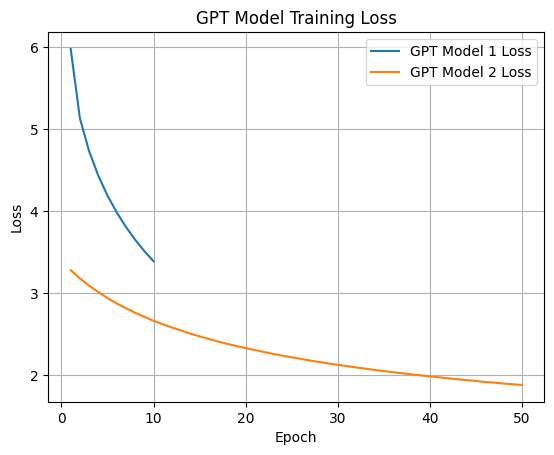

In [ ]:
import matplotlib.pyplot as plt

# Extract the losses during training
### --YOUR CODE HERE-- ###
gpt_loss = gpt_hist.history['loss']
epochs = range(1, len(gpt_loss) + 1)

gpt_loss2 = gpt_hist2.history['loss']
epochs2 = range(1, len(gpt_loss2) + 1)

# Plot the history of losses
### --YOUR CODE HERE-- ###

plt.plot(epochs, gpt_loss, label='GPT Model 1 Loss')

plt.plot(epochs2, gpt_loss2, label='GPT Model 2 Loss')

plt.title('GPT Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Import functions and classes from Keras library
from keras.activations import softmax

# Set five (5) seed sentences
### --CHANGE CODE BELOW-- ###
seed_sentences = [ # provide starting sentences here
    "I am currently working on a new project.",
    "She is dancing gracefully on stage.",
    "They are enjoying their vacation in Hawaii.",
    "We are learning to play the guitar.",
    "He is studying for his upcoming exams."
]

# Define the function to sample from model predictions
def sample_from(logits, k):
  logits, indices = ops.top_k(logits, k, sorted=True)
  indices = np.asarray(indices).astype("int32")
  preds = softmax(ops.expand_dims(logits, 0))[0]
  preds = np.asarray(preds).astype("float32")
  return np.random.choice(indices, p=preds)

# Define the function to generate text
def gpt_output_from_prompt(start_tokens, max_tokens=seq_len, top_k=10):
  start_tokens = [_ for _ in start_tokens]
  num_tokens_generated = 0
  tokens_generated = []
  while num_tokens_generated <= max_tokens:
    pad_len = seq_len - len(start_tokens)
    sample_index = len(start_tokens) - 1
    if pad_len < 0:
      x = start_tokens[:seq_len]
      sample_index = seq_len - 1
    elif pad_len > 0:
      x = start_tokens + [0] * pad_len
    else:
      x = start_tokens
    x = np.array([x])
    y, _ = gpt_model.predict(x, verbose=0)
    sample_token = sample_from(y[0][sample_index], top_k)
    tokens_generated.append(sample_token)
    start_tokens.append(sample_token)
    num_tokens_generated = len(tokens_generated)
  gen_text = " ".join(
      [vocab[index] for index in start_tokens + tokens_generated]
  )
  return gen_text

# Assemble word to index dictionary
word_to_index = {word: index for index, word in enumerate(vocab)}

# Process each starting sentence into tokens
seed_tokens = [[word_to_index.get(word, 1) for word in sentence.split()]
               for sentence in seed_sentences]

# Iterate through the seed sentences
# Apply the gpt_output_from_prompt function as defined above
# for each starting sentence
### --YOUR CODE HERE-- ###
for idx, seed_token in enumerate(seed_tokens):
  print(f"Sample sentence {idx + 1}:")
  print(gpt_output_from_prompt(seed_token))
  print("\n")


Sample sentence 1:
[UNK] am currently working on a new [UNK] will be learning to read using new cars washing cars the cars aiming to begin a legal career into a [UNK] [UNK] latest changes that increase greatly over the past 50 years has a fulltime [UNK] times when the latest seed companies around tell tell around tell tell zones tell of will be learning to read using new cars washing cars the cars aiming to begin a legal career into a [UNK] [UNK] latest changes that increase greatly over the past 50 years has a fulltime [UNK] times when the latest seed companies around tell tell around tell tell zones tell of


Sample sentence 2:
[UNK] is dancing [UNK] on [UNK] the early settlers in the rose by the [UNK] took the english language so many forms of english communication skills and express learning was born in [UNK] a formal english country to measure the night of [UNK] [UNK] 16 the french row across a french french [UNK] french french french french the early settlers in the rose by the [

***

### Machine Problems


### References

[1] Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., Kaiser, Ł., & Polosukhin, I. (2017). *Attention Is All You Need*. Advances in Neural Information Processing Systems, 2017-December, 5999–6009. https://arxiv.org/abs/1706.03762v7

[2] Bahdanau, D., Cho, K. H., & Bengio, Y. (2014). *Neural Machine Translation by Jointly Learning to Align and Translate*. 3rd International Conference on Learning Representations, ICLR 2015 - Conference Track Proceedings. https://arxiv.org/abs/1409.0473v7

[3] Aggarwal, Charu C. *Neural Networks and Deep Learning : A Textbook*. 2nd ed. Cham: Springer International Publishing, 2023.

[4] I. Goodfellow, Y. Bengio and A. Courville, *Deep Learning*. MIT Press, 2016.

[5] *Keras 3 API documentation*. https://keras.io/api/

[6] *WikiAuto Dataset*. https://github.com/chaojiang06/wiki-auto

[7] *Race Dataset*. https://www.cs.cmu.edu/%7Eglai1/data/race/